# Sports Analytics
By: Patrick Bulger, Tim Hulak, Jordan Hyatt, Cal Wardell

## Introduction:

Strategy in American football is more important than perhaps the casual viewer may realize. Football is sometimes referred to as a "game of inches", which was taken from the quote “Football is a game of inches and inches make the champion”, credited to Hall of Fame coach Vince Lombardi. 

In [1]:
# Import Dependencies 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime as dt
from bs4 import BeautifulSoup
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
import os


In [2]:
# Read in data
NFL = pd.read_csv("NFL_Play_By_Play_2009-2018.csv", low_memory=False)

---

## Web Scrape Wikipedia for Season Duration

# Define Analytical Funcions

In [3]:
def team_division(team):
  """Pass in team abbreviation and determine the division the team is in"""
  if team in ["SF","SEA","ARI","LA"]:
    return "NFC West"
  elif team in ["NO","TB","CAR","ATL"]:
    return "NFC South"
  elif team in ["WAS","NYG","DAL","PHI"]:
    return "NFC East"
  elif team in ["GB","CHI","MIN","DET"]:
    return "NFC North"
  elif team in ["KC","OAK","LAC","DEN"]:
    return "AFC West"
  elif team in ["TEN","IND","HOU","JAX"]:
    return "AFC South"
  elif team in ["BUF","MIA","NE","NYJ"]:
    return "AFC East"
  elif team in ["PIT","BAL","CLE","CIN"]:
    return "AFC North"
  else:
    return "Error: Team Not Found"

def team_confrence(team):
  """Pass in team abbreviation and determine the division the team is in"""
  if team in ["SF","SEA","ARI","LA","NO","TB","CAR","ATL","WAS","NYG","DAL","PHI","GB","CHI","MIN","DET"]:
    return "NFC"
  elif team in ["KC","OAK","LAC","DEN","TEN","IND","HOU","JAX","BUF","MIA","NE","NYJ","PIT","BAL","CLE","CIN"]:
    return "AFC"
  else:
    return "Error: Team Not Found"

def penalty_type(pen_team,pos_team):
    """Determine of a penalty is offensive or defensive"""
    if pen_team == pos_team:
        return "Offensive"
    else:
        return "Defensive"

---

# About the Data
The dataset contains 449,371 observations across 255 variables. Each variable represents information about a given play during an NFL football game. Each record represents a specific play during a given game. The data contain information on plays from the 2009 - 2018 season. 

---

---

# Data Exploration

In [4]:
NFL.head(10)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [5]:
NFL.shape

(449371, 255)

In [6]:
NFL.columns

Index(['play_id', 'game_id', 'home_team', 'away_team', 'posteam',
       'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date',
       ...
       'penalty_player_id', 'penalty_player_name', 'penalty_yards',
       'replay_or_challenge', 'replay_or_challenge_result', 'penalty_type',
       'defensive_two_point_attempt', 'defensive_two_point_conv',
       'defensive_extra_point_attempt', 'defensive_extra_point_conv'],
      dtype='object', length=255)

In [7]:
NFL['home_team'].value_counts()

PHI    14510
IND    14322
OAK    14320
CIN    14300
DEN    14290
NE     14270
BUF    14226
GB     14176
CLE    14166
BAL    14158
NYJ    14136
CHI    14112
ARI    14091
KC     14079
DET    14009
SF     14009
NYG    14008
NO     14003
PIT    14001
MIA    13974
TB     13967
HOU    13959
TEN    13920
ATL    13871
MIN    13808
DAL    13788
WAS    13781
CAR    13770
SEA    13603
SD     11007
JAC    10035
STL     9842
LA      4247
JAX     4084
LAC     2529
Name: home_team, dtype: int64

In [8]:
NFL.describe()

,play_id,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,lateral_sack_player_id,lateral_sack_player_name,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
count,449371.000000,4.493710e+05,436301.000000,449230.000000,449206.000000,449208.000000,449371.000000,449371.000000,449371.000000,449371.000000,381409.000000,436664.000000,449371.000000,449371.000000,449158.000000,449371.000000,449371.000000,436497.000000,449371.000000,449371.000000,449371.000000,175719.000000,108907.000000,50740.000000,449371.000000,449371.000000,436497.000000,436492.000000,436492.000000,449371.000000,449371.000000,433952.000000,433952.000000,433952.000000,436492.000000,436492.000000,436492.000000,448693.000000,448693.000000,448693.000000,448693.000000,448693.000000,448693.000000,448693.000000,449371.000000,449371.000000,435812.000000,433535.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,174082.000000,173699.000000,436299.000000,436111.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,433313.000000,4.333130e+05,435388.000000,435388.000000,444050.000000,433334.000000,433334.000000,449371.000000,449371.000000,449371.000000,449371.000000,173940.000000,173724.000000,436156.000000,436064.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,449371.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.000000,436497.0

---

## Data Cleaning

There are many fields in the data that represent the probability of a given action occuring (such as "fg_prob", which represents the probability the team will kick a field goal on that given play). While these advanced metrics are interestinfg, they are not necessary for the analysis and may be removed. This will leave the data with 168 of the 255 columns. 3 teams also changed their team abbreviation during the time span of the data. Since they are the same team, just have a different abbreviation, the old abbreviations were replaced with the new abbreviations. 

### Delete Unneeded Columns
Given the large number of variables, many of them can be discarded. Specificaly the statistical columns for probability after a given play. 

In [9]:
col_del_list = [
  "no_score_prob","opp_fg_prob","opp_safety_prob","opp_td_prob","fg_prob",
  "safety_prob","td_prob","extra_point_prob","two_point_conversion_prob",
  "ep","epa","total_home_epa","total_away_epa","total_home_rush_epa",
  "total_away_rush_epa","total_home_pass_epa","air_epa","yac_epa","comp_air_epa",
  "comp_yac_epa","total_home_comp_air_epa","total_away_comp_air_epa",
  "total_home_comp_yac_epa","total_away_comp_yac_epa","total_home_raw_air_epa",
  "total_away_raw_air_epa","total_home_raw_yac_epa","total_away_raw_yac_epa", 
  "wp", "def_wp","home_wp","away_wp","wpa","home_wp_post","away_wp_post",
  "total_home_rush_wpa","total_away_rush_wpa","total_home_pass_wpa",
  "total_away_pass_wpa","air_wpa","yac_wpa","comp_air_wpa","comp_yac_wpa",
  "total_home_comp_air_wpa","total_away_comp_air_wpa","total_home_comp_yac_wpa",
  "total_home_raw_air_wpa","total_away_raw_air_wpa","total_home_raw_yac_wpa",
  "total_away_raw_yac_wpa","passer_player_id","receiver_player_id",
  "rusher_player_id","lateral_receiver_player_id","lateral_rusher_player_id",
  "lateral_sack_player_id","interception_player_id",
  "lateral_interception_player_id","punt_returner_player_id",
  "lateral_punt_returner_player_id","kickoff_returner_player_id",
  "lateral_kickoff_returner_player_id","punter_player_id","kicker_player_id",
  "own_kickoff_recovery_player_id","blocked_player_id",
  "tackle_for_loss_1_player_id","tackle_for_loss_2_player_id",
  "qb_hit_1_player_id","qb_hit_2_player_id","forced_fumble_player_1_player_id",
  "forced_fumble_player_2_player_id",
  "solo_tackle_1_player_id","solo_tackle_2_player_id","assist_tackle_1_player_id",
  "assist_tackle_2_player_id","assist_tackle_3_player_id",
  "assist_tackle_4_player_id","pass_defense_1_player_id","pass_defense_2_player_id",
  "fumbled_1_player_id","fumbled_2_player_id","fumble_recovery_1_team",
  "fumble_recovery_1_player_id","fumble_recovery_2_player_id","penalty_player_id",
  "total_away_pass_epa"
]

for column in col_del_list:
    del NFL[column]


In [10]:
len(col_del_list)

87

### Team Replacement

There are 32 NFL teams. The data spans from 2009 - 2018 and shows 35 unique teams. During that time frame, 3 NFL teams changed their team abbreviation. The Chargers moved from San Diego, CA to Los Angeles, CA in 2017, therefore their team abbreviation changed from SD to LAC. In 2013, a social media campaign and fan petition saw the Jaguars change their team abbreviation from JAC to JAX. Finally, in 2016 the Rams moved from St. Louis, MO to Los Angeles, CA and their team abbreviation changed from STL to LA. The first step in cleaning the data is to convert the old abbreviations to the new abbreviations in order to analyze team performance as a whole. 

In [11]:
NFL.replace("JAC","JAX",inplace= True)
NFL.replace("SD","LAC",inplace= True)
NFL.replace("STL","LA",inplace= True)

### Adding Columns


In [12]:
# Extract the year
#NFL['game_date'] = pd.to_datetime(NFL['game_date']).dt.date
NFL['game_year'] = pd.to_datetime(NFL['game_date']).dt.year

# Determine the home and away team divis b ons
NFL['posteam_division'] = NFL['posteam'].apply(team_division)
NFL['defteam_division']= NFL['defteam'].apply(team_division)

NFL['posteam_confrence'] = NFL['posteam'].apply(team_confrence)
NFL['defteam_confrence']= NFL['defteam'].apply(team_confrence)

NFL['penalty_team_division'] = NFL['penalty_team'].apply(team_division)
NFL['penalty_team_confrence'] = NFL['penalty_team'].apply(team_confrence)

NFL['penalty_side'] = NFL.apply(lambda x: penalty_type(x.penalty_team, x.posteam), axis=1)

---

### Scrape NFL.com for team win/loss

In [13]:
def scrape_records():
    odf = pd.DataFrame() 
    for year in range(2009,2019):
        url=f'https://www.nfl.com/standings/division/{year}/REG'
        for sdf in pd.read_html(url):
            sdf = sdf.iloc[:,:4]
            sdf.columns = ['team','W','L','T']
            sdf['season'] = f'season_{year}'
            odf = odf.append(sdf)
    def get_team_abbr(name):
        team_dict = {
            'browns':'CLE','bucc':'TB','bills':'BUF','titans':'TEN','dolphins':'MIA',
            'jaguars':'JAX','jets':'NYJ','washington':'WAS','bears':'CHI', 'giants':'NYG',
            'cardinals':'ARI','49ers':'SF','rams':'LA','lions':'DET','seahawks':'SEA',
            'panthers':'CAR','cowboys':'DAL','chargers':'LAC','vikings':'MIN','falcons':'ATL',
            'texans':'HOU','broncos':'DEN','eagles':'PHI','patriots':'NE','steelers':'PIT',
            'saints':'NO','ravens':'BAL','bengals':'CIN','colts':'IND','chiefs':'KC',
            'packers':'GB','raiders':'OAK'
        }
        for key in team_dict.keys():
            if key in name.lower(): return team_dict[key]
        return 'NOT FOUND'
    odf['team']=odf.team.apply(get_team_abbr)
    return odf.reset_index(drop=True)
records = scrape_records()
records['record'] = records['W'].astype(str)+"-"+records['L'].astype(str)+"-"+records['T'].astype(str)

In [14]:
def get_season(date):
    if type(date)==str: date = pd.to_datetime(date)
    year = date.year
    if date.month<5: year = year-1
    return f'season_{year}'
NFL['season'] = pd.to_datetime(NFL['game_date']).apply(get_season)

NFL.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,total_away_comp_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_name,receiver_player_name,rusher_player_name,lateral_receiver_player_name,lateral_rusher_player_name,lateral_sack_player_name,interception_player_name,lateral_interception_player_name,punt_returner_player_name,lateral_punt_returner_player_name,kickoff_returner_player_name,lateral_kickoff_returner_player_name,punter_player_name,kicker_player_name,own_kickoff_recovery_player_name,blocked_player_name,tackle_for_loss_1_player_name,tackle_for_loss_2_player_name,qb_hit_1_player_name,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_name,assist_tackle_4_team,pass_defense_1_player_name,pass_defense_2_player_name,fumbled_1_team,fumbled_1_player_name,fumbled_2_player_name,fumbled_2_team,fumble_recovery_1_yards,fumble_recovery_1_player_name,fumble_recovery_2_team,fumble_recovery_2_yards,fumble_recovery_2_player_name,return_team,return_yards,penalty_team,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,game_year,posteam_division,defteam_division,posteam_confrence,defteam_confrence,penalty_team_division,penalty_team_confrence,penalty_side,season
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,900.0,1800.0,3600.0,Half1,0,1,0,1,NaN,0.0,15:00,TEN 30,0,0,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,kickoff,0.0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,NaN,NaN,3,3,0.0,NaN,NaN,3.0,3.0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S.Logan,NaN,NaN,R.Bironas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEN,NaN,M.Griffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIT,39.0,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,AFC North,AFC South,AFC,AFC,Error: Team Not Found,Error: Team Not Found,Defensive,season_2009
1,68,20090

---

# Tim: What are the effects of penalties on team performance?


#### Team Color Codes

In [15]:
# colors from https://teamcolorcodes.com/nfl-team-color-codes/
team_colors = {
    "NFL":['#003069','#d60303','#005d00'],
    "AFC": ['#003069','#d60303','#005d00'],
    "NFC": ['#003069','#d60303','#005d00'],
    'ARI': ['#97233F','#000000','#FFB612'],
     'ATL': ['#A71930','#000000','#A5ACAF'],
     'BAL': ['#241773','#000000','#9E7C0C'],
     'BUF': ['#00338D','#C60C30','gray'],
     'CAR': ['#0085CA','#101820','#BFC0BF'],
     'CHI': ['#0B162A','#C83803','gray'],
     'CIN': ['#FB4F14','#000000','gray'],
     'CLE': ['#311D00','#FF3C00','gray'],
     'DAL': ['#003594','#869397','black'],
     'DEN': ['#FB4F14','#002244','gray'],
     'DET': ['#0076B6','#B0B7BC','#000000'],
     'GB': ['#203731','#FFB612','gray'],
     'HOU': ['#03202F','#A71930','gray'],
     'IND': ['#002C5F','#A2AAAD','gray'],
     'JAX': ['#101820','#D7A22A','#006778'],
     'KC': ['#E31837','#FFB81C','#000000'],
     'LA': ['#003594','#FFD100','#FFA300'],
     'LAC': ['#0080C6','#FFC20E','gray'],
     'MIA': ['#008E97','#FC4C02','#005778'],
     'MIN': ['#4F2683','#FFC62F','gray'],
     'NE': ['#002244','#C60C30','#B0B7BC'],
     'NO': ['#D3BC8D','#101820','gray'],
     'NYG': ['#0B2265','#A71930','#A5ACAF'],
     'NYJ': ['#125740','#000000','#046A38'],
     'OAK': ['#000000','#A5ACAF','gray'],
     'PHI': ['#004C54','#004C54','#565A5C'],
     'PIT': ['#FFB612','#101820','#A5ACAF'],
     'SEA': ['#002244','#69BE28','#A5ACAF'],
     'SF': ['#AA0000','#B3995D','#000000'],
     'TB': ['#D50A0A',' #B1BABF','#0A0A08'],
     'TEN': ['#0C2340','#4B92DB','#C8102E'],
     'WAS': ['#773141','#FFB612','gray']
}

### Further slice the data for penalty-related columns

In [16]:
penalty_slice = NFL.loc[NFL.penalty == 1.0]
penalty_df = penalty_slice[['penalty','penalty_team','penalty_player_name','penalty_yards','penalty_type',
                            'penalty_team_division','penalty_team_confrence', 'penalty_side',
                            'posteam','defteam',
                            'yardline_100','game_half','down','ydstogo','play_type',
                            'shotgun','no_huddle','qb_dropback','qb_scramble','pass_length','pass_location',
                            'air_yards','yards_after_catch','run_location','run_gap',
                            'rush_attempt','pass_attempt','sack','touchdown','posteam_division','defteam_division',
                            'posteam_confrence','defteam_confrence','season']]
penalty_df.head()


,penalty,penalty_team,penalty_player_name,penalty_yards,penalty_type,penalty_team_division,penalty_team_confrence,penalty_side,posteam,defteam,yardline_100,game_half,down,ydstogo,play_type,shotgun,no_huddle,qb_dropback,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,rush_attempt,pass_attempt,sack,touchdown,posteam_division,defteam_division,posteam_confrence,defteam_confrence,season
15,1.0,PIT,T.Polamalu,15.0,Unnecessary Roughness,AFC North,AFC,Defensive,TEN,PIT,89.0,Half1,1.0,10,run,0,0,0.0,0,NaN,NaN,NaN,NaN,right,end,1.0,0.0,0.0,0.0,AFC South,AFC North,AFC,AFC,season_2009
26,1.0,TEN,D.Stewart,5.0,Illegal Formation,AFC South,AFC,Offensive,TEN,PIT,64.0,Half1,1.0,10,no_play,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,AFC South,AFC North,AFC,AFC,season_2009
46,1.0,PIT,H.Ward,10.0,Offensive Holding,AFC North,AFC,Offensive,PIT,TEN,70.0,Half1,2.0,1,run,0,0,0.0,0,NaN,NaN,NaN,NaN,right,guard,1.0,0.0,0.0,0.0,AFC North,AFC South,AFC,AFC,season_2009
47,1.0,PIT,M.Starks,10.0,Offensive Holding,AFC North,AFC,Offensive,PIT,TEN,75.0,Half1,2.0,6,no_play,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,AFC North,AFC South,AFC,AFC,season_2009
61,1.0,PIT,T.Polamalu,15.0,NaN,AFC North,AFC,Defensive,TEN,PIT,40.0,Half1,3.0,7,pass,1,0,1.0,0,short,left,5.0,3.0,NaN,NaN,0.0,1.0,0.0,0.0,AFC South,AFC North,AFC,AFC,season_2009


# High Level of NFL Penalties

## Penalties in the NFL

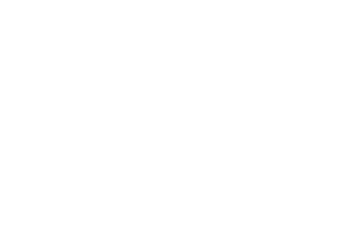

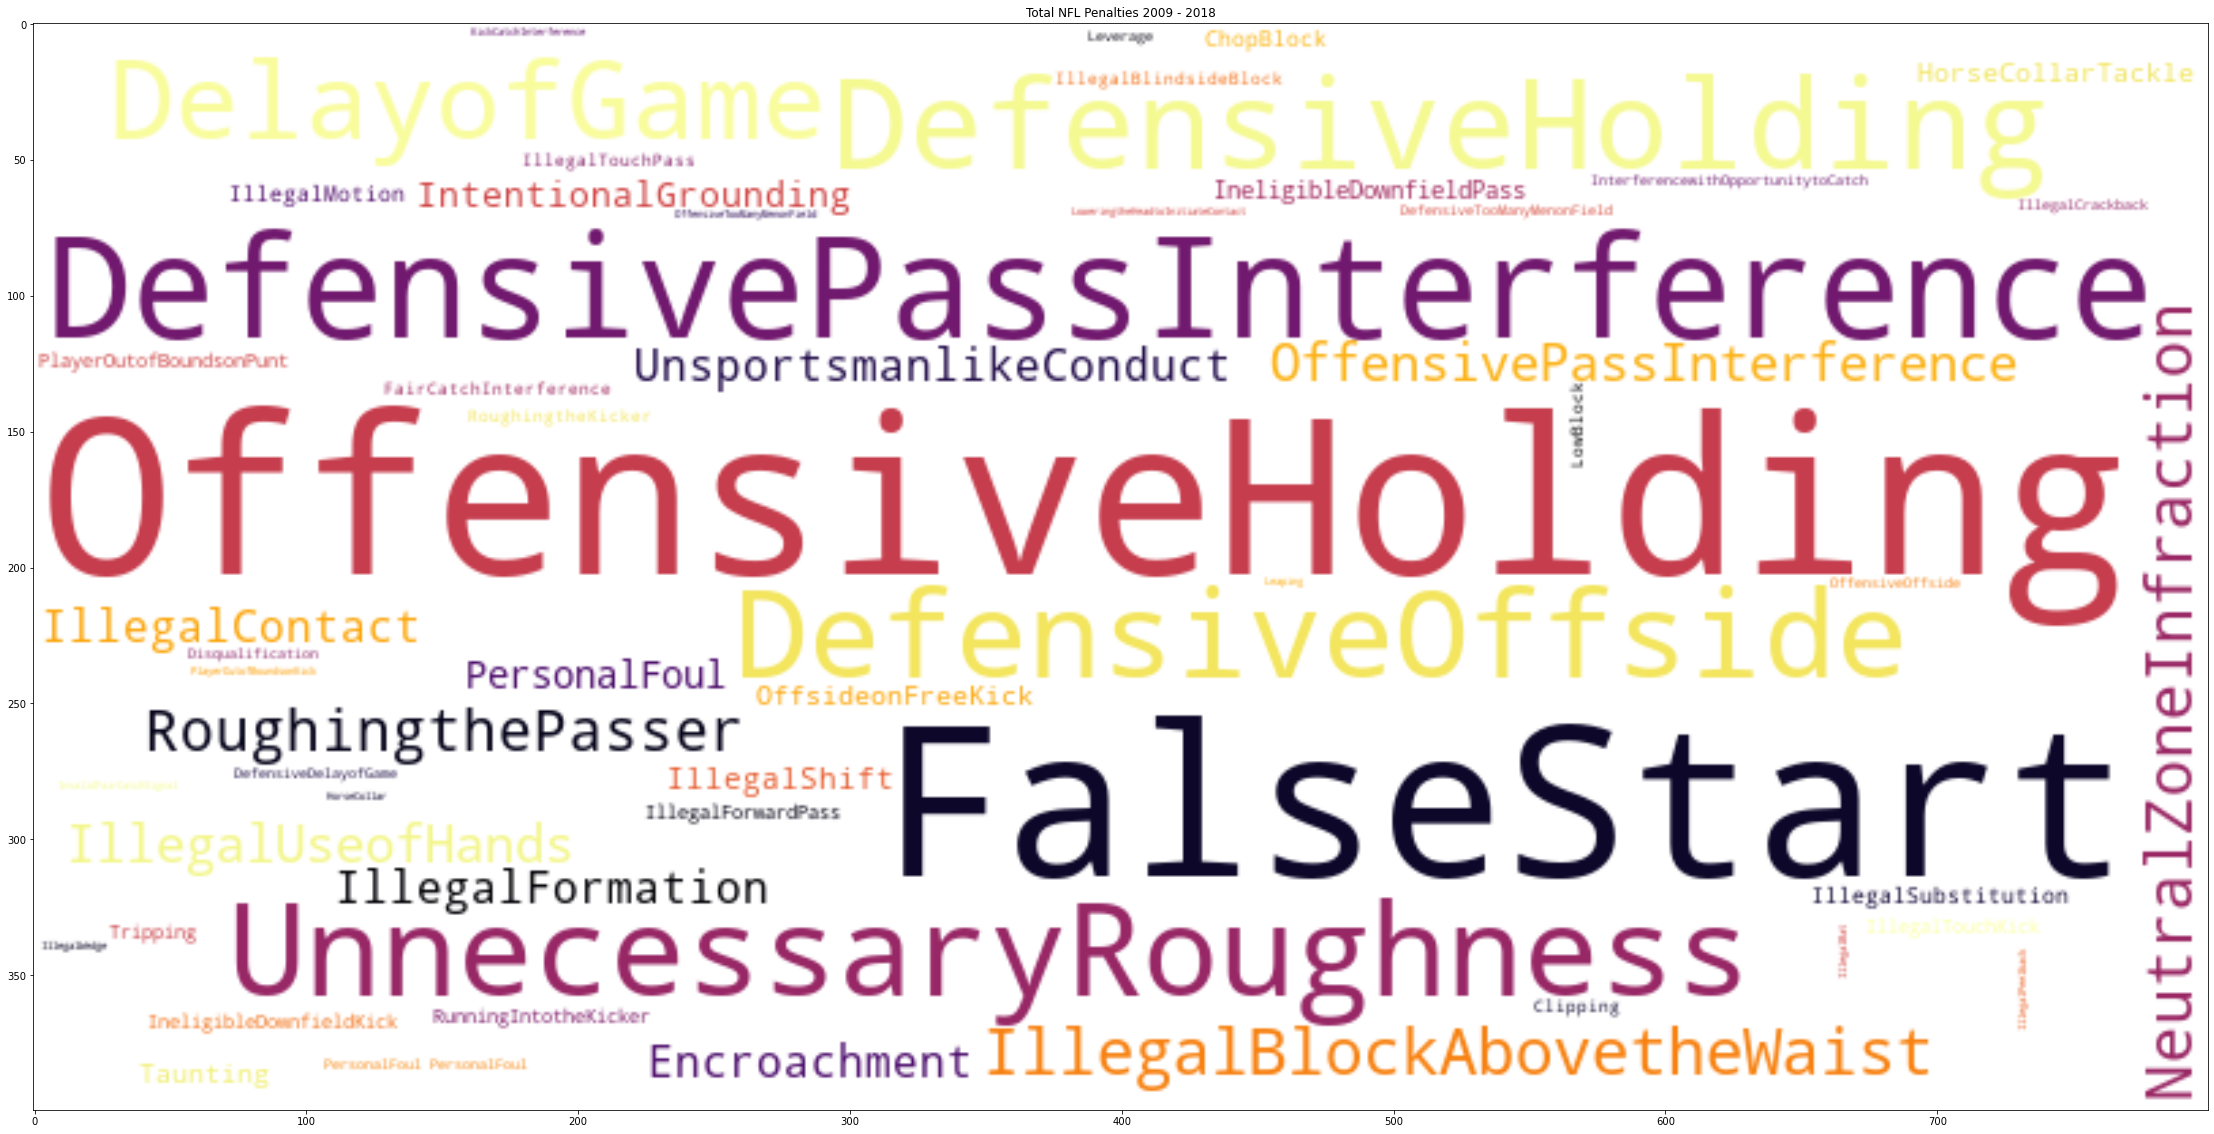

In [17]:
text = " ".join(review for review in penalty_df.penalty_type.astype(str).str.replace(" ", ""))
text = text.replace('nan','')
wordcloud = WordCloud(background_color="white", width=800, height=400, colormap='inferno_r').generate(text)
plt.axis("off")
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Total NFL Penalties 2009 - 2018")
plt.show()


### Average Defensive Pass Interference

In [18]:
defensivePI = penalty_df[penalty_df['penalty_type'] == 'Defensive Pass Interference']
defensivePI.penalty_yards.mean()

17.499325842696628

### Top 5 Penalties Commited by count

In [19]:
top5pen = penalty_df['penalty_type'].value_counts().head().to_frame().reset_index()
top5pen.columns = ['Penalty','Count']
top5pen

,Penalty,Count
0,Offensive Holding,6250
1,False Start,5793
2,Defensive Pass Interference,2225
3,Unnecessary Roughness,1794
4,Defensive Holding,1731


### Top 5 Penalties Commited by Yards

In [20]:
top5penyds = penalty_df.groupby(['penalty_type']).penalty_yards.sum().sort_values(ascending=False).head().to_frame().reset_index()
top5penyds.columns = ['Penalty','Total Yards']
top5penyds

,Penalty,Total Yards
0,Offensive Holding,59788.0
1,Defensive Pass Interference,38936.0
2,False Start,28469.0
3,Unnecessary Roughness,24254.0
4,Roughing the Passer,12227.0


In [21]:
top5penyds.Penalty

0              Offensive Holding
1    Defensive Pass Interference
2                    False Start
3          Unnecessary Roughness
4            Roughing the Passer
Name: Penalty, dtype: object

In [22]:
top5penyds['Total Yards'].sum()

163674.0

In [23]:
penalty_df['penalty_yards'].sum()

276856.0

In [24]:
round(top5penyds['Total Yards'].sum() / penalty_df['penalty_yards'].sum(),4)

0.5912

#### NFL Penalties by type YoY

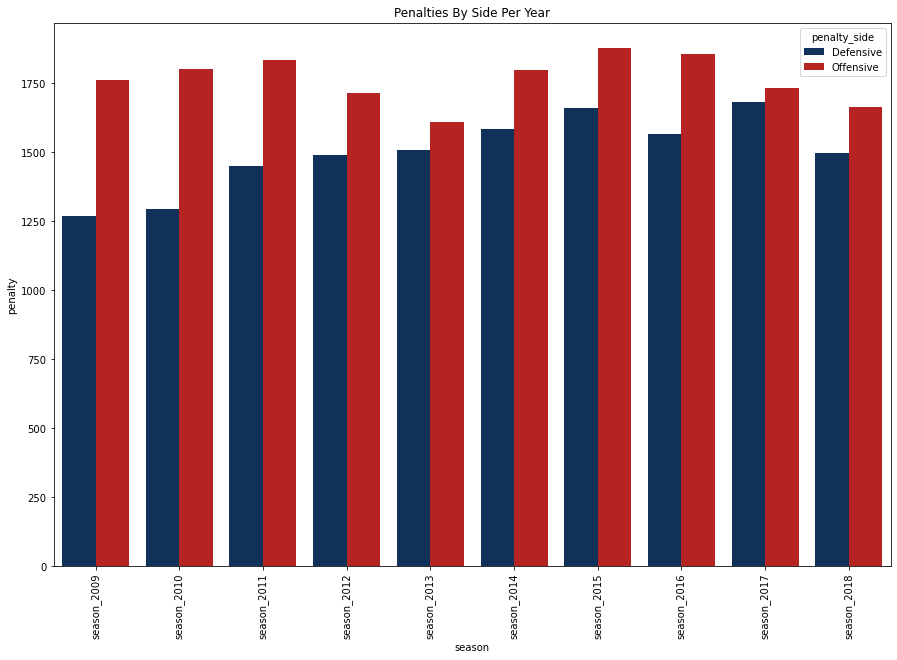

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(x="season", y="penalty", hue="penalty_side", palette = team_colors['NFL'], saturation = 0.7, data=penalty_df.groupby(["penalty_side",'season'], as_index=False)["penalty"].sum())
plt.xticks(rotation = 90)
plt.title("Penalties By Side Per Year")
plt.show()

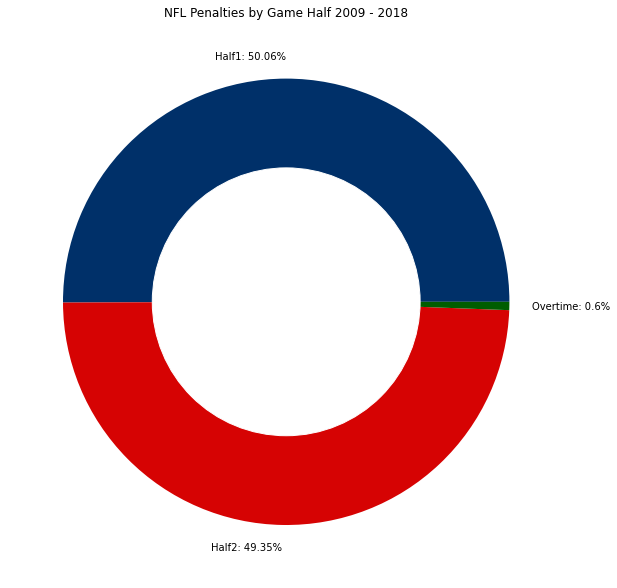

In [26]:
names = penalty_df['game_half'].unique().tolist()

labels = []

for i in penalty_df['game_half'].unique():
    labels.append(f"{i}: {round(len(penalty_df[penalty_df['game_half'] == i])/len(penalty_df['game_half']),4)*100}%")

size = [len(penalty_df[penalty_df['game_half'] == names[0]]),\
        len(penalty_df[penalty_df['game_half'] == names[1]]),\
       len(penalty_df[penalty_df['game_half'] == names[2]])]
size
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.6, color='white')

plt.figure(figsize=(10,15))

# Custom wedges
plt.pie(size, labels=labels, colors = team_colors['NFL'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("NFL Penalties by Game Half 2009 - 2018")
plt.show()

### Offensive Penaties: Select Team

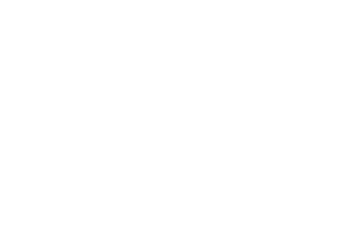

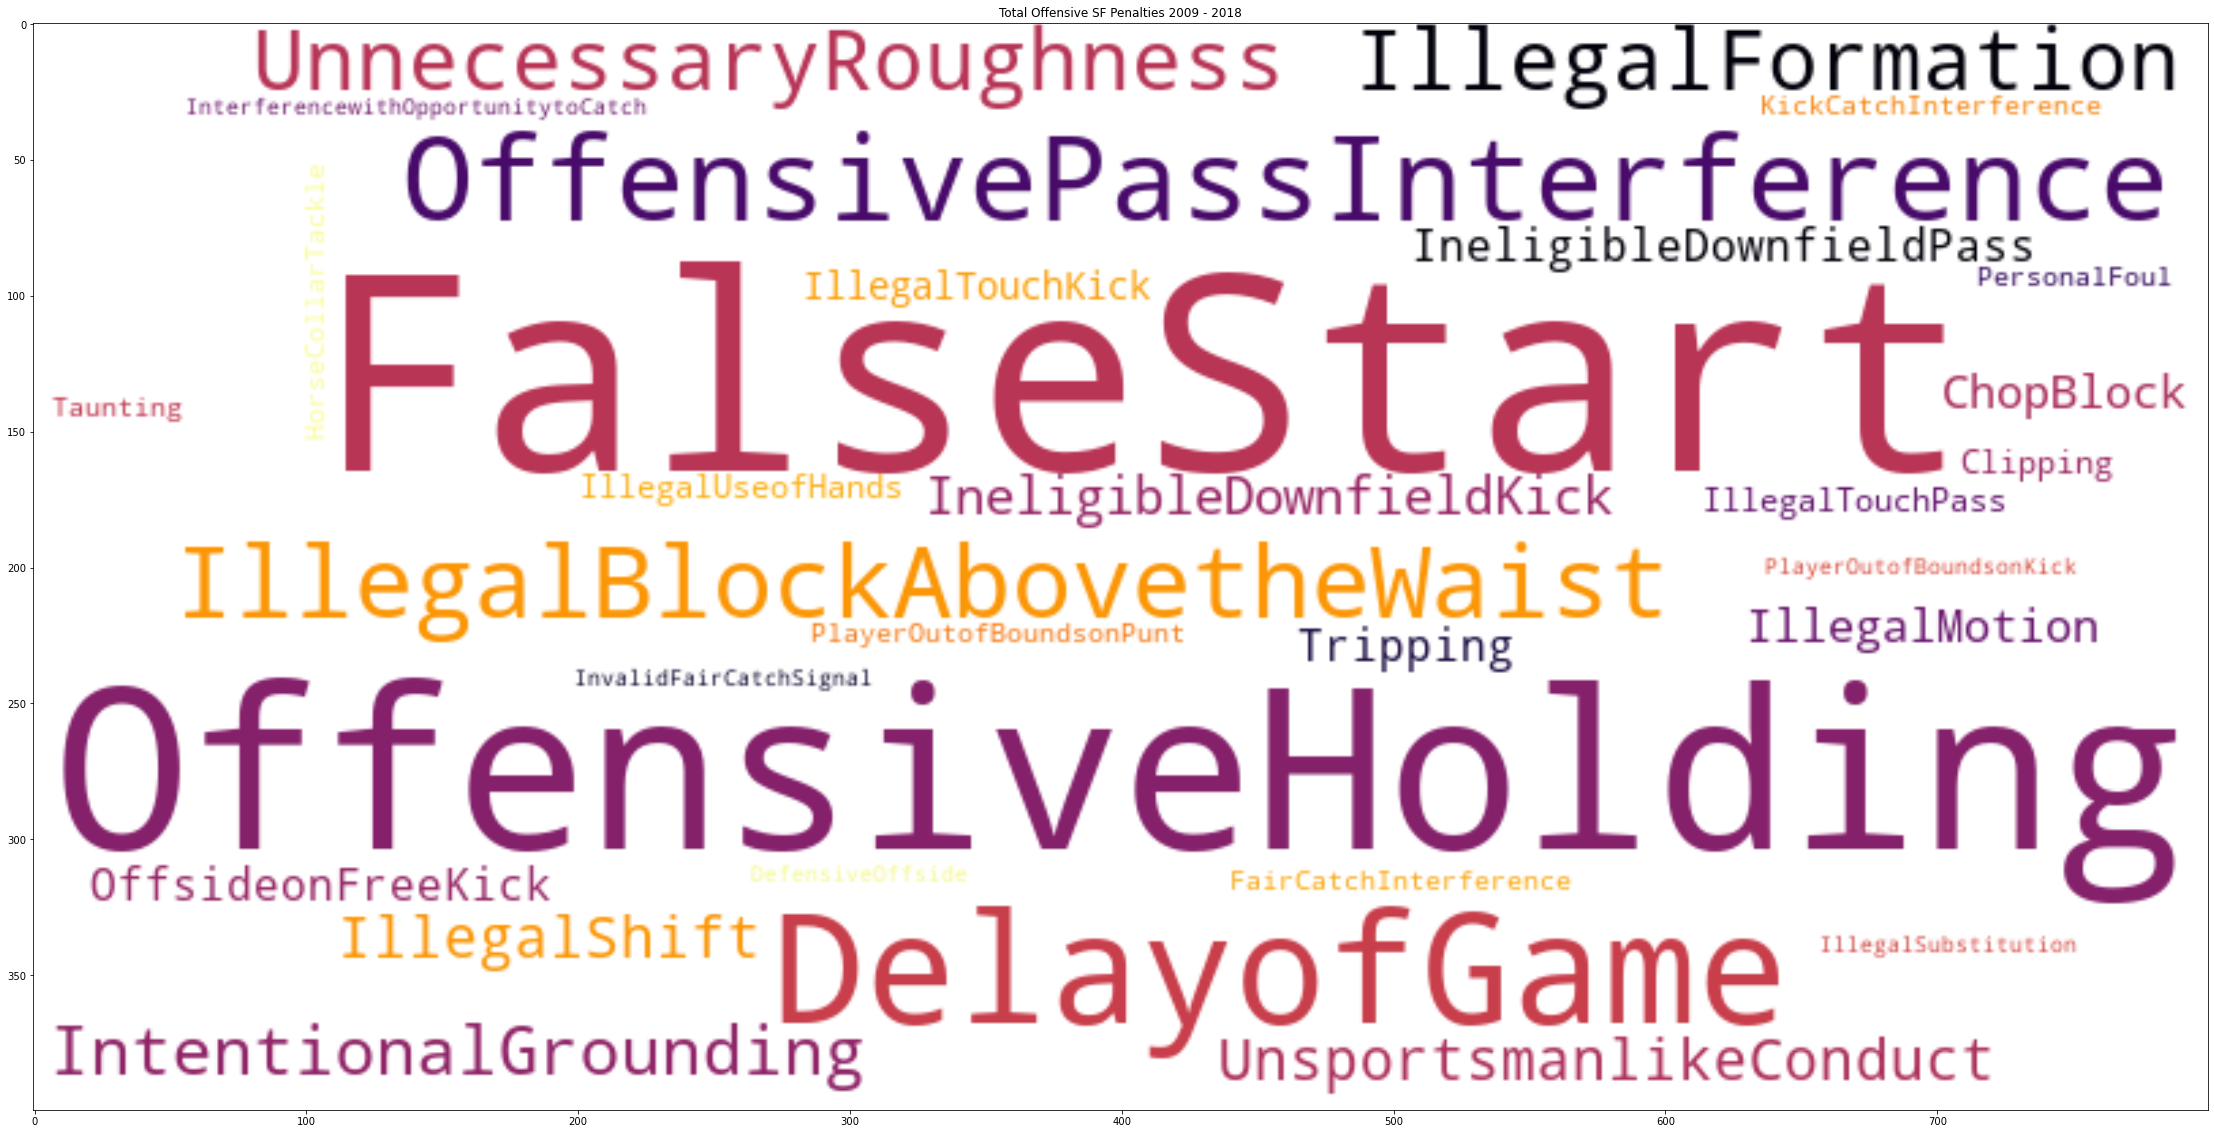

In [27]:
def offensive_penalty_team(team):
    """ Produces a wordcloud of offensive penatly frequency of a user provided team abbreviation"""

    team_off_pen_df = penalty_df[(penalty_df['penalty_team'] == team) & (penalty_df['posteam'] == team)]

    text = " ".join(review for review in team_off_pen_df.penalty_type.astype(str).str.replace(" ", ""))
    text = text.replace('nan','')
    wordcloud = WordCloud(background_color="white", width=800, height=400, colormap='inferno_r').generate(text)
    plt.axis("off")
    plt.figure(figsize=(40,20))
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Total Offensive {team} Penalties 2009 - 2018")
    plt.show()
offensive_penalty_team("SF")

### Defensive Penatlites: Select Team

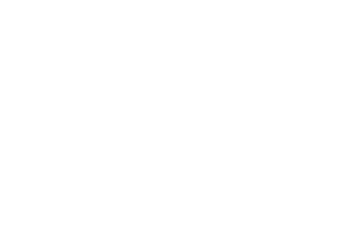

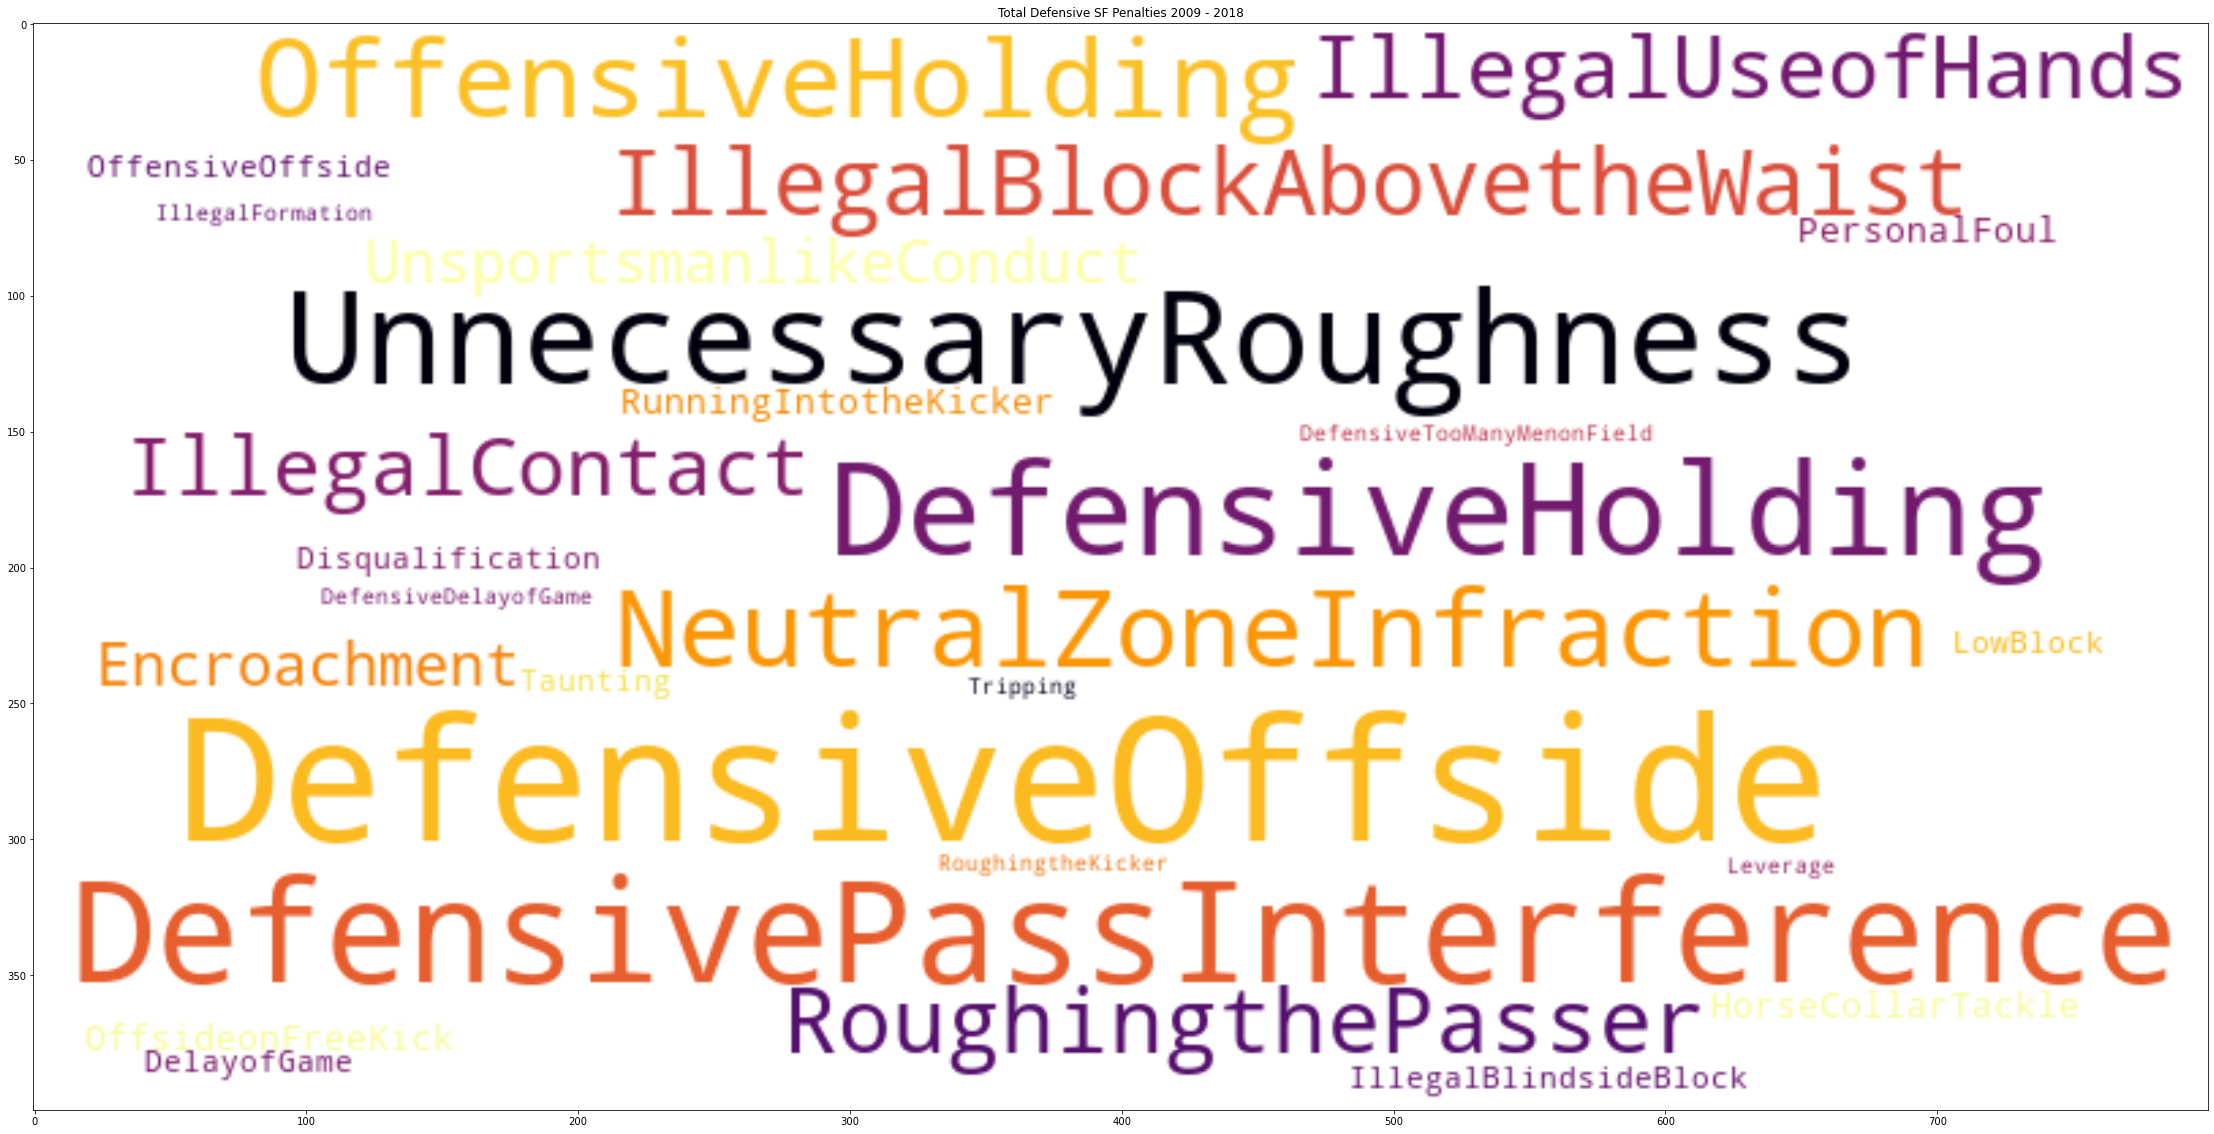

In [28]:
def defensive_penalty_team(team):
    """ Produces a wordcloud of defensive penatly frequency of a user provided team abbreviation"""
    team_def_pen_df = penalty_df[(penalty_df['penalty_team'] == team) & (penalty_df['defteam'] == team)]

    text = " ".join(review for review in team_def_pen_df.penalty_type.astype(str).str.replace(" ", ""))
    text = text.replace('nan','')
    wordcloud = WordCloud(background_color="white", width=800, height=400, colormap='inferno_r').generate(text)
    plt.axis("off")
    plt.figure(figsize=(40,20))
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Total Defensive {team} Penalties 2009 - 2018")
    plt.show()
defensive_penalty_team("SF")

In [29]:
team_penalty_yards = penalty_df.groupby(['penalty_team','season','penalty_type','penalty_side'], as_index=False)['penalty_yards'].mean()
division_penalty_yards = penalty_df.groupby(['penalty_team_division','season','penalty_type','penalty_side'], as_index=False)['penalty_yards'].mean()
confrence_penalty_yards = penalty_df.groupby(['penalty_team_confrence','season','penalty_type','penalty_side'], as_index=False)['penalty_yards'].mean()

In [30]:
def avg_penalty_yards(team):
    """
    Aggregate Total, Offensive, and Defensive penalty yards of a team and return the 
    average penalty yards of a team in a barplot along with the average penalty yards
    of the team's confrence and division. It will also display the record for the season
    on the chart and color the plot with team colors
    """
    off_team = records.loc[records['team'] == team]
    
    record_list = off_team['record'].tolist()
    
    # Total
    total_3 = confrence_penalty_yards.loc[(confrence_penalty_yards['penalty_team_confrence'] == team_confrence(team))]
    total_3.rename(columns={'penalty_team_confrence':'Avg'}, inplace=True)
    total_2 = division_penalty_yards.loc[division_penalty_yards['penalty_team_division'] == team_division(team)]
    total_2.rename(columns={'penalty_team_division':'Avg'}, inplace=True)
    total_1 = team_penalty_yards.loc[team_penalty_yards['penalty_team'] == team]
    total_1.rename(columns={'penalty_team':'Avg'}, inplace=True)
    total_data = pd.concat([total_1,total_2,total_3],ignore_index=True)
    
    # Offensive
    off_3 = confrence_penalty_yards.loc[(confrence_penalty_yards['penalty_team_confrence'] == team_confrence(team)) &
                                   (confrence_penalty_yards['penalty_side'] == "Offensive")]
    off_3.rename(columns={'penalty_team_confrence':'Avg'}, inplace=True)
    off_2 = division_penalty_yards.loc[(division_penalty_yards['penalty_team_division'] == team_division(team)) & 
                                      (division_penalty_yards['penalty_side'] == "Offensive")]
    off_2.rename(columns={'penalty_team_division':'Avg'}, inplace=True)
    off_1 = team_penalty_yards.loc[(team_penalty_yards['penalty_team'] == team) &
                                  (team_penalty_yards['penalty_side'] == "Offensive")]
    off_1.rename(columns={'penalty_team':'Avg'}, inplace=True)
    off_data = pd.concat([off_1,off_2,off_3],ignore_index=True)
    
    # Defensive
    def_3 = confrence_penalty_yards.loc[(confrence_penalty_yards['penalty_team_confrence'] == team_confrence(team)) &
                                   (confrence_penalty_yards['penalty_side'] == "Defensive")]
    def_3.rename(columns={'penalty_team_confrence':'Avg'}, inplace=True)
    def_2 = division_penalty_yards.loc[(division_penalty_yards['penalty_team_division'] == team_division(team)) & 
                                      (division_penalty_yards['penalty_side'] == "Defensive")]
    def_2.rename(columns={'penalty_team_division':'Avg'}, inplace=True)
    def_1 = team_penalty_yards.loc[(team_penalty_yards['penalty_team'] == team) &
                                  (team_penalty_yards['penalty_side'] == "Defensive")]
    def_1.rename(columns={'penalty_team':'Avg'}, inplace=True)
    def_data = pd.concat([def_1,def_2,def_3],ignore_index=True)
    
    # Plots
    fig, axs = plt.subplots(nrows=3, figsize = (10,15))

    sns.barplot(x = 'season',
            y = 'penalty_yards',
            hue = 'Avg',
            data =  total_data,
            ci=None,
            palette = team_colors[team], ax=axs[0])
    sns.barplot(x = 'season',
            y = 'penalty_yards',
            hue = 'Avg',
            data =  off_data,
            ci=None,
            palette= team_colors[team], ax=axs[1])
    sns.barplot(x = 'season',
            y = 'penalty_yards',
            hue = 'Avg',
            data =  def_data,
            ci=None,
            palette= team_colors[team], ax=axs[2])
    

    
    titles = ['Total Avg Penalty Yards','Offensive Avg Penalty Yards','Defensive Avg Penalty Yards']
    counter = 0
    for chart in range(0,3):
        axs[chart].set_xticklabels(labels = total_1.season.unique().tolist(), rotation = 90)
        axs[chart].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
        axs[chart].title.set_text(titles[chart])
        axs[chart].set_ylim([0,12])
        axs[chart].set_xlabel("Season")
        axs[chart].set_ylabel("Avg Yards")
        
        for rec in range(len(record_list)):
            axs[chart].text(counter-0.31, 10.7, record_list[rec])
            counter +=1
        counter = 0
            
        
            
       
    plt.tight_layout()
    plt.show()

### Test function and analyze historically low and high flagged teams

/Users/timhulak/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


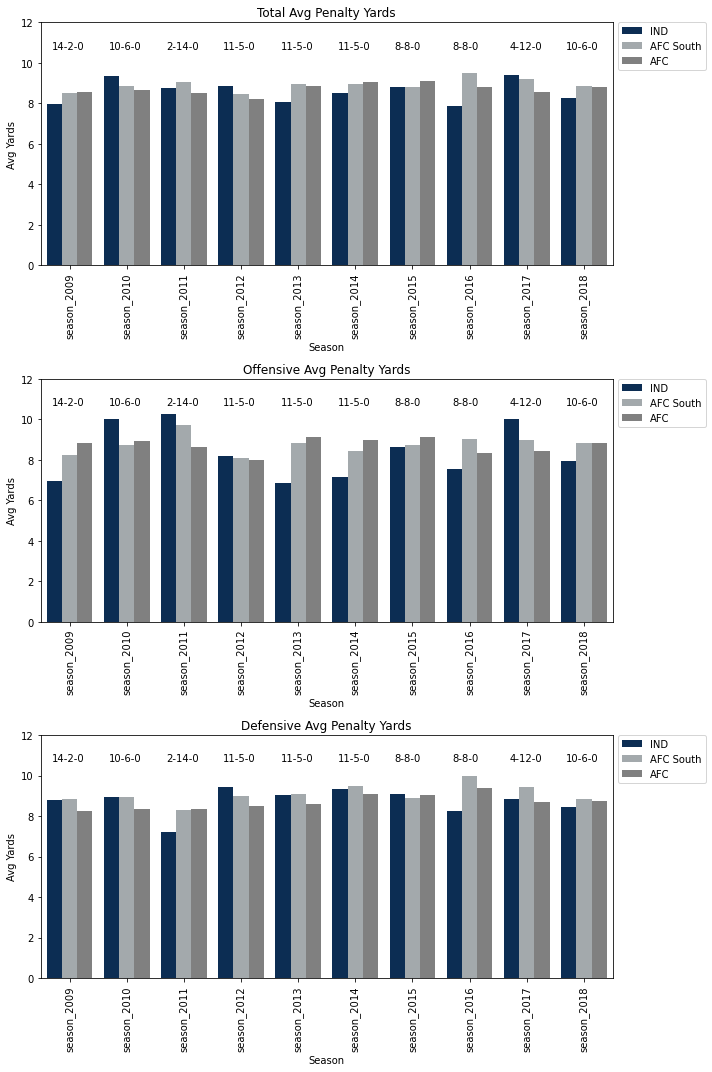

In [31]:
avg_penalty_yards("IND")

/Users/timhulak/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


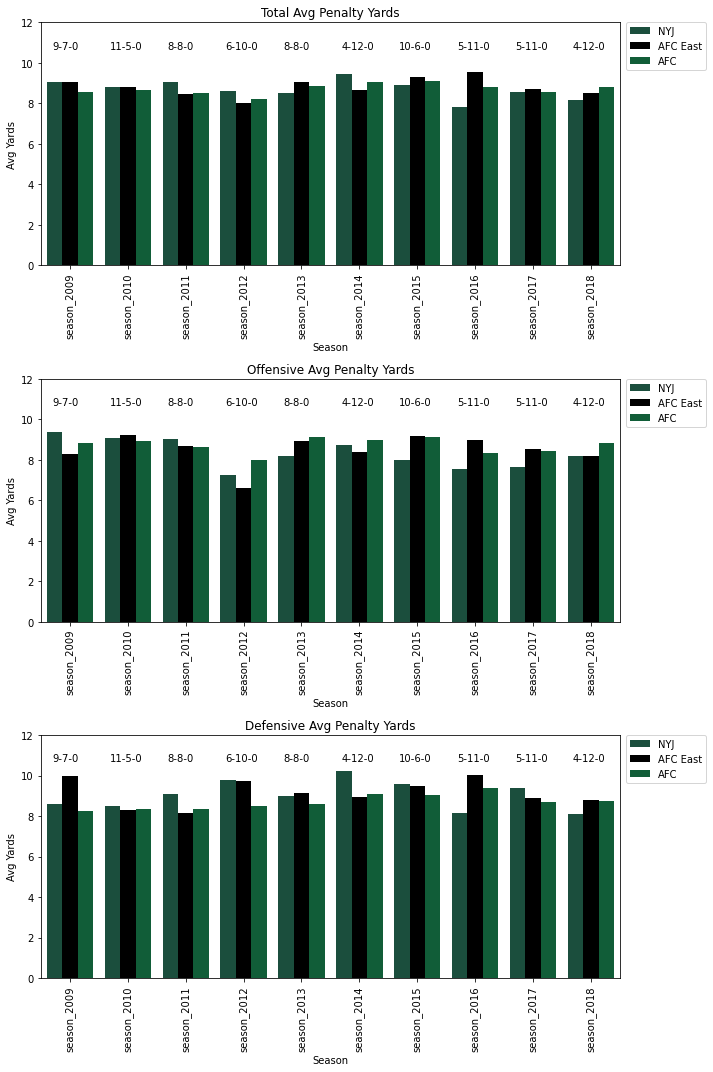

In [32]:
avg_penalty_yards("NYJ")

/Users/timhulak/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


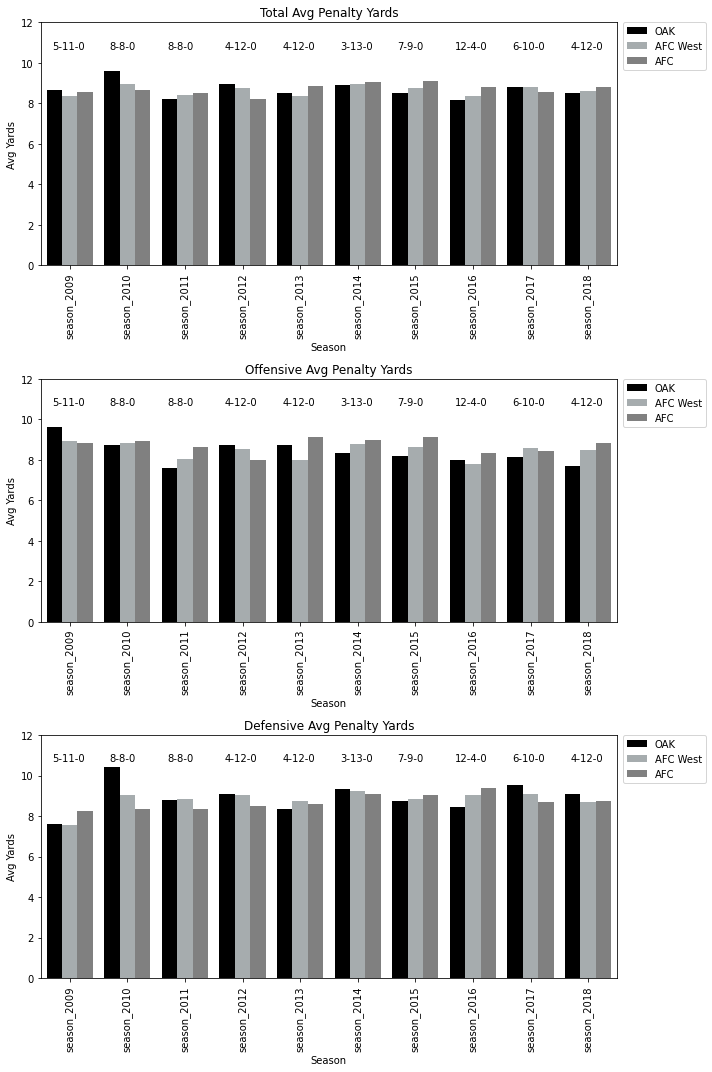

In [33]:
avg_penalty_yards("OAK")

### Analyze Gamre Half penalties for teams

In [34]:
def team_penalties_game_half(team):
    team_penalty_df = penalty_df[penalty_df['penalty_team'] == team]

    names = team_penalty_df['game_half'].unique().tolist()

    labels = []

    for i in team_penalty_df['game_half'].unique():
        labels.append(f"{i}: {round(len(team_penalty_df[team_penalty_df['game_half'] == i])/len(team_penalty_df['game_half']),4)*100}%")

    size = [len(team_penalty_df[team_penalty_df['game_half'] == names[0]]),\
            len(team_penalty_df[team_penalty_df['game_half'] == names[1]]),\
           len(team_penalty_df[team_penalty_df['game_half'] == names[2]])]
    size
    # Create a circle at the center of the plot
    my_circle = plt.Circle( (0,0), 0.6, color='white')

    plt.figure(figsize=(10,15))

    # Custom wedges
    plt.pie(size, labels=labels, colors = team_colors[team])
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(f"{team} Penalties by Game Half 2009 - 2018")
    plt.show()
    



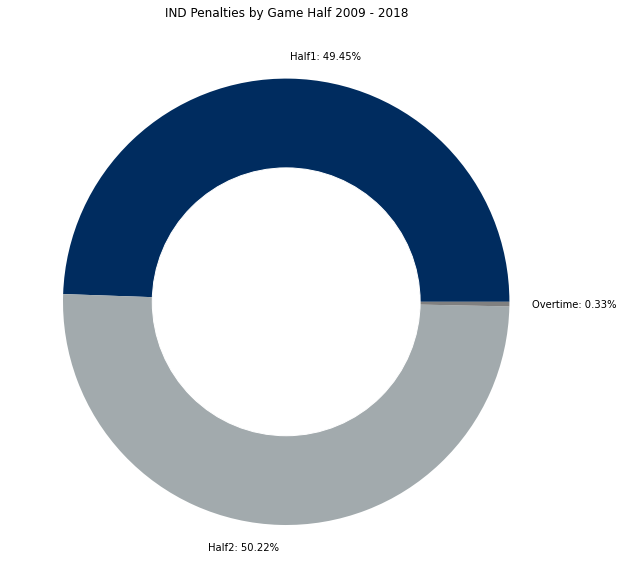

In [35]:
team_penalties_game_half("IND")

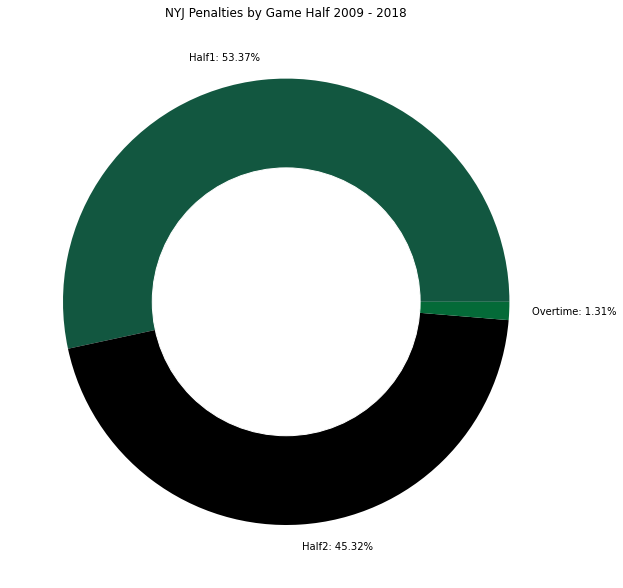

In [36]:
team_penalties_game_half("NYJ")

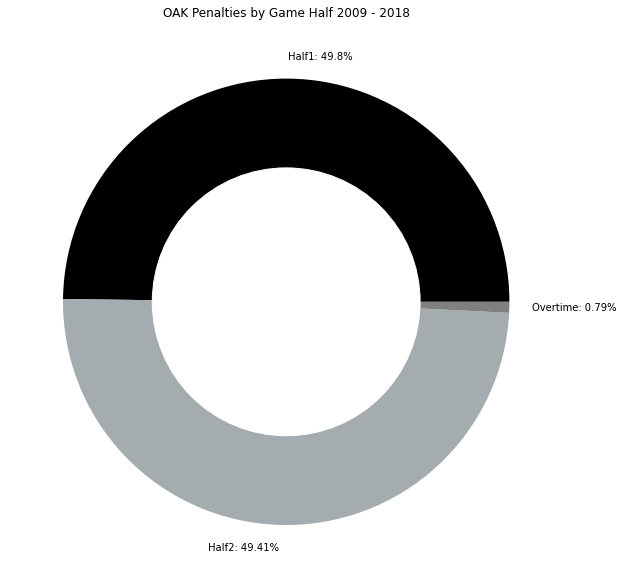

In [37]:
team_penalties_game_half("OAK")

In [38]:
NFL.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,total_away_comp_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_name,receiver_player_name,rusher_player_name,lateral_receiver_player_name,lateral_rusher_player_name,lateral_sack_player_name,interception_player_name,lateral_interception_player_name,punt_returner_player_name,lateral_punt_returner_player_name,kickoff_returner_player_name,lateral_kickoff_returner_player_name,punter_player_name,kicker_player_name,own_kickoff_recovery_player_name,blocked_player_name,tackle_for_loss_1_player_name,tackle_for_loss_2_player_name,qb_hit_1_player_name,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_name,assist_tackle_4_team,pass_defense_1_player_name,pass_defense_2_player_name,fumbled_1_team,fumbled_1_player_name,fumbled_2_player_name,fumbled_2_team,fumble_recovery_1_yards,fumble_recovery_1_player_name,fumble_recovery_2_team,fumble_recovery_2_yards,fumble_recovery_2_player_name,return_team,return_yards,penalty_team,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,game_year,posteam_division,defteam_division,posteam_confrence,defteam_confrence,penalty_team_division,penalty_team_confrence,penalty_side,season
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,900.0,1800.0,3600.0,Half1,0,1,0,1,NaN,0.0,15:00,TEN 30,0,0,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,kickoff,0.0,0,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,NaN,NaN,3,3,0.0,NaN,NaN,3.0,3.0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S.Logan,NaN,NaN,R.Bironas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEN,NaN,M.Griffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIT,39.0,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,2009,AFC North,AFC South,AFC,AFC,Error: Team Not Found,Error: Team Not Found,Defensive,season_2009
1,68,20090

In [ ]:
plt.scatter()